In [1]:
from keras.models import Model
from keras.layers import Input,Dense
import  numpy as np
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf
from keras.layers import *
from keras.datasets import fashion_mnist

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
1.0 -1.0
1.0 -3.0
1.0 -7.0
1.0 -15.0


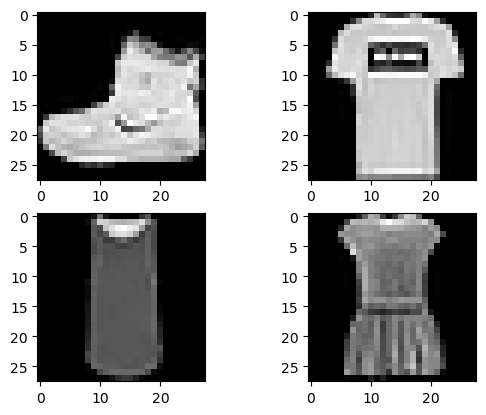

In [2]:
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()
train_x = train_x/255.
val_x = val_x/255.
train_x=train_x.reshape(-1,28,28,1)
print(train_x.shape)
#train_x = train_x.reshape(-1, 784)
#val_x = val_x.reshape(-1, 784)
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
  for j in range(2):
    axe[i,j].imshow(train_x[idx].reshape(28,28),cmap='gray')
    idx+=1
    train_x = train_x*2 - 1
    print(train_x.max(),train_x.min())



In [3]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                      

In [4]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)              

In [5]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.summary()
epochs = 30
batch_size = 100
noise_shape=100
with tf.device('/gpu:0'):
  for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    for i in range(train_x.shape[0]//batch_size):
      if (i+1)%100 == 0:
        print(f"\tCurrently on batch number {i+1} of {train_x.shape[0]//batch_size}")
      noise=np.random.normal(size=[batch_size,noise_shape])
      gen_image = generator.predict_on_batch(noise)
      train_dataset = train_x[i*batch_size:(i+1)*batch_size]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         320656    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 242179    
                                                                 
Total params: 562835 (2.15 MB)
Trainable params: 318864 (1.22 MB)
Non-trainable params: 243971 (953.01 KB)
_________________________________________________________________
Currently on Epoch 1
	Currently on batch number 100 of 600
	Currently on batch number 200 of 600
	Currently on batch number 300 of 600
	Currently on batch number 400 of 600
	Currently on batch number 500 of 600
	Currently on batch number 600 of 600
Currently on Epoch 2
	Currently on batch number 100 of 600
	Currently on batch number 200 of 600
	Currently on batch number 300 of 600
	Currently on batch numb

In [6]:
#training discriminator on real images
train_label=np.ones(shape=(batch_size,1))
#train_label=np.ones((batch_size, 1))
discriminator.trainable = True
#train_dataset=train_x[idx]
d_loss_real=discriminator.train_on_batch(train_dataset,train_label) #training discriminator on fake images train_label=np.zeros(shape=(batch_size,1))
d_loss_fake=discriminator.train_on_batch(gen_image,train_label)

1/1 [==============================] - 1s 630ms/step


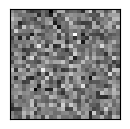

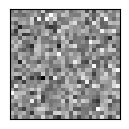

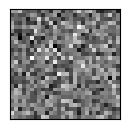

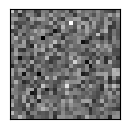

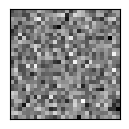

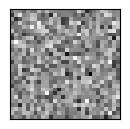

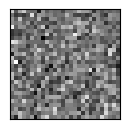

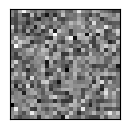

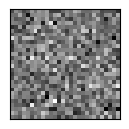

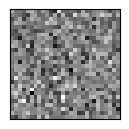

In [7]:
#training generator
noise=np.random.normal(size=[batch_size,noise_shape])
train_label=np.ones(shape=(batch_size,1))
discriminator.trainable = False
d_g_loss_batch =GAN.train_on_batch(noise, train_label)
#plotting generated images at the start and then after every 10 epoch if epoch % 10 == 0:
samples = 10
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
for k in range(samples):
  plt.subplot(2, 5, k+1)
  plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
  plt.show()


Training is complete
1/1 [==============================] - 0s 64ms/step


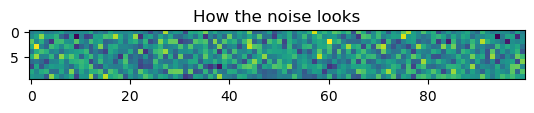

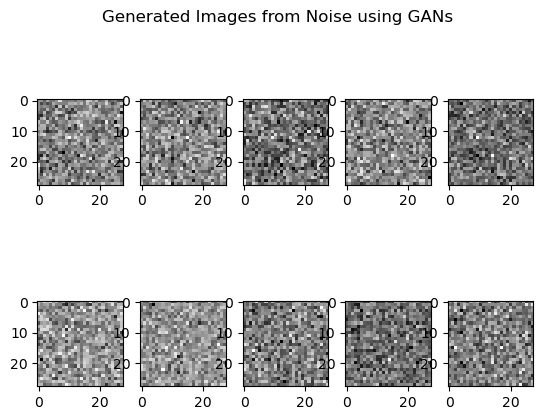

In [8]:
print('Training is complete')
noise=np.random.normal(size=[10,noise_shape])
gen_image = generator.predict(noise)
plt.imshow(noise)
plt.title('How the noise looks')
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
  for j in range(5):
    axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
    idx+=1